In [1]:
#INSTALLAZIONE
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.4.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.9/542.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.6/792.6 kB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.9 MB/s eta 0:00:00


In [2]:
# IMPORT DELLE LIBRERIE
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from torch_geometric.data import HeteroData
from torch_geometric.nn import GATConv
from torch_geometric.utils import degree
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cpu.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cpu.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_spline_conv/_version_cpu.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue oc

In [3]:
# CONFIGURAZIONE DEVICE (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
# CARICAMENTO E PREPARAZIONE DATI ATC
atc = pd.read_csv('/content/atc_clean.csv', dtype=str).fillna("") # tutte stringhe e rimpiazza i Nan con ""

# Normalizzazione dei campi
atc["code"]   = atc["code"].astype(str).str.upper().str.strip()
atc["parent"] = atc["parent"].astype(str).str.upper().str.strip()
atc["level"]  = atc["level"].astype(int)

# Rimuovi righe senza code (se esistono)
atc = atc[atc["code"] != ""].copy()

# Controllo duplicati
dup = atc["code"].duplicated().sum()
if dup > 0:
    print(f"Trovati {dup} codici ATC duplicati.")
    atc = atc.drop_duplicates(subset=["code"], keep="first").copy()

In [5]:
# CREAZIONE MAPPING NODI ATC
# Indici nodi ATC, creazione dizionario code → node_idx
atc_idx = {c:i for i,c in enumerate(atc["code"].tolist())}

# Aggiunta colonna node_idx al DataFrame
atc["node_idx"] = atc["code"].map(atc_idx)

print("Esempio di mappatura ATC:", list(atc_idx.items())[:5])
print(atc.head(5))

Esempio di mappatura ATC: [('A', 0), ('B', 1), ('C', 2), ('D', 3), ('G', 4)]
  code                                    name  level parent  node_idx
0    A         ALIMENTARY TRACT AND METABOLISM      1                0
1    B          BLOOD AND BLOOD FORMING ORGANS      1                1
2    C                   CARDIOVASCULAR SYSTEM      1                2
3    D                         DERMATOLOGICALS      1                3
4    G  GENITO URINARY SYSTEM AND SEX HORMONES      1                4


In [6]:
# CREAZIONE ARCHI DELLA GERARCHIA ATC
# Creare connessione tra i nodi ATC, dove ogni livello punta al suo genitore
edges_df  = atc[atc["parent"]!=""].copy() # Tiene solo i nodi che partecipano a un arco ovvero solo i codici che hanno un parent

# Mappa parent code → parent index
edges_df ["parent_idx"] = edges_df ["parent"].map(atc_idx)

# Teniamo solo le righe con parent trovato
edges_df  = edges_df [edges_df ["parent_idx"].notna()].copy()
edges_df ["node_idx"]   = edges_df ["node_idx"].astype(int)
edges_df ["parent_idx"] = edges_df ["parent_idx"].astype(int)

# Crea tensore archi: [child_indices, parent_indices]
edge_atc = torch.tensor(
    np.vstack([edges_df ["node_idx"].to_numpy(), edges_df ["parent_idx"].values]),
    dtype=torch.long
)

print("Primi 5 archi ATC (child → parent):")
for i in range(min(5, len(edges_df ))):
    child = edges_df .iloc[i]["code"]
    parent = edges_df .iloc[i]["parent"]
    print(f"  {child} → {parent}")

print("\nTensor edge_atc:")
print(edge_atc)
print("Forma del tensore:", edge_atc.shape) # (2, numArchi)

# Aggiungiamo anche gli archi inversi parent -> child
edge_atc_rev = edge_atc.flip(0) # Inverte l'ordine della prima dimensione
edge_index_atc = torch.cat([edge_atc, edge_atc_rev], dim=1) # Tensore con tutti gli archi

print("Forma del tensore (bidirezionale):", edge_index_atc.shape)

Primi 5 archi ATC (child → parent):
  A01 → A
  A02 → A
  A03 → A
  A04 → A
  A05 → A

Tensor edge_atc:
tensor([[  14,   15,   16,  ..., 6437, 6438, 6439],
        [   0,    0,    0,  ..., 1285, 1285, 1285]])
Forma del tensore: torch.Size([2, 6426])
Forma del tensore (bidirezionale): torch.Size([2, 12852])


In [7]:
# COSTRUZIONE GRAFO ETEROGENEO
data = HeteroData() # Contenitore grafi eterogenei

# Numero nodi ATC
num_atc_nodes = len(atc_idx)
data["atc"].num_nodes = num_atc_nodes

# Ordina DataFrame per node_idx per garantire allineamento
atc_sorted = atc.sort_values("node_idx")

# Feature iniziali dei nodi: one-hot del livello ATC
levels = torch.tensor(atc_sorted["level"].to_numpy(), dtype=torch.long)
x_atc = F.one_hot(levels - 1, num_classes=5).to(torch.float)  # (NumNodi, 5) rappresento le categorie come un vettore con num_classes numero di elementi del vettore. Ogni riga e' il nodo atc e la colonna e' il livello
data["atc"].x = x_atc # x = matrice delle feature dei nodi, cioè ciò che descrive ogni nodo in forma numerica

print("Feature nodi ATC shape:", data["atc"].x.shape)

# Archi ATC <-> ATC
data["atc", "rel_atc", "atc"].edge_index = edge_index_atc

print(data)

Feature nodi ATC shape: torch.Size([6440, 5])
HeteroData(
  atc={
    num_nodes=6440,
    x=[6440, 5],
  },
  (atc, rel_atc, atc)={ edge_index=[2, 12852] }
)


In [8]:
# FEATURE ENGINEERING: ARRICCHIMENTO FEATURE DEI NODI
def build_enriched_node_features(atc_df, atc_idx, edge_index, device):
    """
    Crea feature arricchite per ogni nodo combinando:
    1. One-hot encoding del livello gerarchico (5 dimensioni)
    2. Grado entrante normalizzato (log1p)
    3. Grado uscente normalizzato (log1p)
    4. Profondità normalizzata nella gerarchia

    Args:
        atc_df: DataFrame con i dati ATC
        atc_idx: Dizionario code → node_idx
        edge_index: Tensore degli archi [2, num_edges]
        device: Device PyTorch (cuda/cpu)

    Returns:
        Tensor di shape (num_nodes, 8): feature arricchite
        - 5 dimensioni: one-hot livello
        - 1 dimensione: in-degree normalizzato
        - 1 dimensione: out-degree normalizzato
        - 1 dimensione: profondità normalizzata
    """
    num_nodes = len(atc_idx)

    # One-hot del livello
    atc_sorted = atc_df.sort_values("node_idx")
    levels = torch.tensor(atc_sorted["level"].to_numpy(), dtype=torch.long)  # (N,)
    x_level = F.one_hot(levels - 1, num_classes=5).to(torch.float)          # (N,5)

    # Calcolo gradi (in-degree e out-degree)
    src, dst = edge_index[0], edge_index[1]
    out_degree = degree(src, num_nodes=num_nodes)
    in_degree = degree(dst, num_nodes=num_nodes)

    # Normalizzazione logaritmica
    in_degree_norm = torch.log1p(in_degree).unsqueeze(1)
    out_degree_norm = torch.log1p(out_degree).unsqueeze(1)

    depth_norm = (levels.float() / levels.max()).unsqueeze(1)

    # Concatena tutte le feature
    x = torch.cat([x_level, in_degree_norm, out_degree_norm, depth_norm], dim=1)
    return x.to(device)

# Sostituisci le feature nel grafo
x_enriched = build_enriched_node_features(
    atc_df=atc,
    atc_idx=atc_idx,
    edge_index=data["atc", "rel_atc", "atc"].edge_index.cpu(),
    device=device
)
data["atc"].x = x_enriched

In [9]:
# PREPARAZIONE ETICHETTE DI TRAINING
def prepare_atc_labels(atc_df, atc_idx, device):
    """
    Prepara le etichette target per il training supervisionato:
    - Categoria anatomica (prima lettera del codice ATC: A, B, C, ...)
    - Livello gerarchico (1-5 convertito in 0-4)

    Args:
        atc_df: DataFrame con i dati ATC
        atc_idx: Dizionario code → node_idx
        device: Device PyTorch (cuda/cpu)

    Returns:
        tuple: (cat_labels, level_labels, cat_unique)
            - cat_labels: Tensor [num_nodes] con categoria per ogni nodo
            - level_labels: Tensor [num_nodes] con livello per ogni nodo
            - cat_unique: Lista delle categorie uniche (per num_classes)
    """
    num_nodes = len(atc_idx)
    # Crea lista di codici allineata agli indici dei nodi
    codes = [None] * num_nodes
    for code, idx in atc_idx.items():
        codes[idx] = code

    # ETICHETTE CATEGORIA (Ogni categoria e' un etichetta)
    # Estrai la prima lettera del codice (A, B, C, ...)
    categories = [c[0] if c else "X" for c in codes]
    cat_unique = sorted(set(categories))
    cat_to_num = {c:i for i,c in enumerate(cat_unique)}
    cat_labels = torch.tensor(
        [cat_to_num[c] for c in categories],
        dtype=torch.long,
        device=device
        )

    # ETICHETTE LIVELLO
    # Creazione mapping code → level
    code_to_level = dict(zip(
        atc_df["code"].astype(str).str.upper().str.strip(),
        atc_df["level"].astype(int)
    ))
    level_labels = torch.tensor(
        [code_to_level.get(c, 1) - 1 for c in codes],
        dtype=torch.long,
        device=device
        )

    return cat_labels, level_labels, cat_unique

cat_labels, level_labels, cat_unique = prepare_atc_labels(atc, atc_idx, device)

In [10]:
# DEFINIZIONE MODELLO: GRAPH ATTENTION NETWORK (GAT)
# Una GAT fa una cosa semplice in teoria. Ogni nodo guarda i suoi vicini e calcola una combinazione pesata delle loro feature.
class ATCGraphEncoder(nn.Module):
    """
    Graph Neural Network basata su Graph Attention Network (GAT).

    Architettura:
    - 4 layer GAT con attention multi-head
    - Skip connections tramite concatenazione
    - Dropout per regolarizzazione
    - Due head di classificazione (categoria e livello)

    Il modello impara embeddings che:
    1. Rispettano la gerarchia ATC (nodi parent-child vicini)
    2. Separano bene le categorie anatomiche (A, B, C, ...)
    3. Codificano il livello gerarchico (1-5)
    """
    def __init__(self, in_dim, hidden_dim=64, embedding_dim=128, num_categories=14, dropout=0.2):
        """
        Args:
            in_dim: Dimensione input features (8 nel nostro caso)
            hidden_dim: Dimensione hidden layer (64)
            embedding_dim: Dimensione embedding finale (128)
            num_categories: Numero di categorie anatomiche (A, B, C, ...)
            dropout: Probabilità di dropout (0.2 = 20%)
        """
        super().__init__()
        self.dropout = dropout

        self.conv1 = GATConv(in_dim, hidden_dim, heads=2, concat=True, dropout=dropout)
        self.conv2 = GATConv(hidden_dim*2, hidden_dim, heads=2, concat=True, dropout=dropout)
        self.conv3 = GATConv(hidden_dim*2, hidden_dim, heads=2, concat=True, dropout=dropout)
        self.conv4 = GATConv(hidden_dim*2, embedding_dim, heads=1, concat=False, dropout=dropout)

        self.category_head = nn.Linear(embedding_dim, num_categories)
        self.level_head = nn.Linear(embedding_dim, 5)

    def forward(self, x, edge_index, solo_embeddings=False):
        h = F.elu(self.conv1(x, edge_index))
        h = F.dropout(h, p=self.dropout, training=self.training)

        h = F.elu(self.conv2(h, edge_index))
        h = F.dropout(h, p=self.dropout, training=self.training)

        h = F.elu(self.conv3(h, edge_index))
        h = F.dropout(h, p=self.dropout, training=self.training)

        embeddings = self.conv4(h, edge_index)

        if solo_embeddings:
            return embeddings

        cat_pred = self.category_head(embeddings)
        lvl_pred = self.level_head(embeddings)
        return embeddings, cat_pred, lvl_pred

encoder = ATCGraphEncoder(
    in_dim=data["atc"].x.shape[1],
    hidden_dim=64,
    embedding_dim=128,
    num_categories=len(cat_unique),
    dropout=0.2
).to(device)

In [11]:
# FUNZIONI DI LOSS PERSONALIZZATE
def hierarchy_pull_loss(embeddings, edge_child_parent):
    """
    Loss che avvicina gli embeddings di nodi child ai loro parent.

    Questa loss è fondamentale per fare in modo che la gerarchia ATC
    sia rispettata nello spazio degli embeddings: un farmaco (livello 5)
    deve essere vicino al suo gruppo terapeutico (livello 4), che deve
    essere vicino al sottogruppo (livello 3), ecc.

    Args:
        embeddings: Tensor [num_nodes, embedding_dim] degli embeddings
        edge_child_parent: Tensor [2, num_edges] con archi child→parent

    Returns:
        Distanza L2 media tra embeddings child-parent
    """
    child_idx = edge_child_parent[0]
    parent_idx = edge_child_parent[1]

    # Calcola distanza L2 al quadrato tra ogni coppia child-parent
    distances = (embeddings[child_idx] - embeddings[parent_idx]).pow(2).sum(dim=1)

    return distances.mean()

In [12]:
# FUNZIONE DI TRAINING
def train_gnn(model, data, cat_labels, level_labels,
              num_epochs=300, lr=0.005, w_level=0.5, w_hier=0.1, edge_child_parent=None):
    """
    Addestra la GNN con loss multi-task:
    - Classificazione categoria anatomica (A, B, C, ...)
    - Classificazione livello gerarchico (1-5)
    - Preservazione gerarchia (child vicino a parent)

    Args:
        model: Il modello GNN da addestrare
        data: HeteroData con grafo ATC
        cat_labels: Etichette categoria [num_nodes]
        level_labels: Etichette livello [num_nodes]
        edge_child_parent: Archi child→parent [2, num_edges]
        num_epochs: Numero di epoche di training
        lr: Learning rate
        w_level: Peso della loss livello
        w_hier: Peso della loss gerarchia
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    # Sposto tutto sul device corretto
    device = data["atc"].x.device
    cat_labels = cat_labels.to(device)
    level_labels = level_labels.to(device)

    model.train()

    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        embeddings, cat_pred, lvl_pred = model(
            data["atc"].x,
            data["atc", "rel_atc", "atc"].edge_index,
            solo_embeddings=False
        )

        # Calcolo le 3 loss
        loss_cat = criterion(cat_pred, cat_labels)
        loss_lvl = criterion(lvl_pred, level_labels)
        loss_hier = hierarchy_pull_loss(embeddings, edge_child_parent)

        # Loss totale
        loss = loss_cat + w_level * loss_lvl + w_hier * loss_hier

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            acc_cat = (cat_pred.argmax(1) == cat_labels).float().mean().item()
            acc_lvl = (lvl_pred.argmax(1) == level_labels).float().mean().item()
            print(
                f"Epoca {epoch+1:3d} | Loss {loss.item():.4f} | "
                f"Cat {loss_cat.item():.4f} | Lvl {loss_lvl.item():.4f} | Hier {loss_hier.item():.4f} | "
                f"AccCat {acc_cat:.3f} | AccLvl {acc_lvl:.3f}"
            )

In [13]:
# TRAINING DEL MODELLO
# Verifica che edge_atc sia valido
assert edge_atc is not None, "edge_atc non può essere None!"
assert edge_atc.shape[0] == 2, "edge_atc deve avere shape [2, num_edges]"

train_gnn(
    encoder,
    data.to(device),
    cat_labels,
    level_labels,
    edge_child_parent=edge_atc,
    num_epochs=300,
    lr=0.005,
    w_level=0.5,
    w_hier=0.1,
)

Epoca  20 | Loss 2.8544 | Cat 2.5147 | Lvl 0.5887 | Hier 0.4538 | AccCat 0.120 | AccLvl 0.812
Epoca  40 | Loss 2.7798 | Cat 2.5000 | Lvl 0.4928 | Hier 0.3342 | AccCat 0.133 | AccLvl 0.817
Epoca  60 | Loss 2.7561 | Cat 2.4902 | Lvl 0.4798 | Hier 0.2604 | AccCat 0.134 | AccLvl 0.818
Epoca  80 | Loss 2.7408 | Cat 2.4850 | Lvl 0.4528 | Hier 0.2942 | AccCat 0.138 | AccLvl 0.827
Epoca 100 | Loss 2.7262 | Cat 2.4767 | Lvl 0.4289 | Hier 0.3510 | AccCat 0.144 | AccLvl 0.836
Epoca 120 | Loss 2.7039 | Cat 2.4550 | Lvl 0.4279 | Hier 0.3500 | AccCat 0.155 | AccLvl 0.836
Epoca 140 | Loss 2.6691 | Cat 2.4039 | Lvl 0.4001 | Hier 0.6515 | AccCat 0.182 | AccLvl 0.846
Epoca 160 | Loss 2.6347 | Cat 2.3690 | Lvl 0.4177 | Hier 0.5684 | AccCat 0.190 | AccLvl 0.842
Epoca 180 | Loss 2.5820 | Cat 2.3087 | Lvl 0.4161 | Hier 0.6528 | AccCat 0.222 | AccLvl 0.857
Epoca 200 | Loss 2.5366 | Cat 2.2537 | Lvl 0.4283 | Hier 0.6878 | AccCat 0.241 | AccLvl 0.843
Epoca 220 | Loss 2.4550 | Cat 2.1633 | Lvl 0.4249 | Hier 0.7

In [14]:
# ESTRAZIONE EMBEDDINGS FINALI
encoder.eval()

with torch.no_grad():
    atc_embeddings = encoder(
        data["atc"].x,
        data["atc", "rel_atc", "atc"].edge_index,
        solo_embeddings=True
    ).detach().cpu()

print("Embeddings shape:", atc_embeddings.shape)

def save_atc_embeddings_npz(atc_embeddings, atc_idx, out_path="atc_embeddings.npz"):
    # allinea i codici all'ordine degli embeddings
    num_nodes = atc_embeddings.shape[0]
    codes = [None] * num_nodes
    for code, idx in atc_idx.items():
        codes[idx] = code

    codes_np = np.array(codes, dtype=object)
    emb_np = atc_embeddings.detach().cpu().numpy().astype(np.float32)

    np.savez(out_path, atc_code=codes_np, embedding=emb_np)
    print(f"Salvati {len(codes_np)} embedding in: {out_path}")

save_atc_embeddings_npz(atc_embeddings, atc_idx, out_path="/content/atc_embeddings.npz")

Embeddings shape: torch.Size([6440, 128])
Salvati 6440 embedding in: /content/atc_embeddings.npz


In [25]:
'''
#Per riprendere gli embedding dal file
data = np.load("atc_embeddings.npz", allow_pickle=True)

embeddings = data["embedding"]
atc_codes  = data["atc_code"]
'''

[[ 0.15406704  0.08559281  0.07042094 ... -0.05771433 -0.10633826
   0.00149134]
 [-0.072588    0.18416038 -0.16337147 ...  0.06605347  0.22477755
  -0.1554813 ]
 [ 0.00308962  0.18592751  0.22201444 ... -0.03630544 -0.01332447
   0.16671896]
 ...
 [-0.0824623   0.23056765  0.0769235  ... -0.1040875  -0.10481198
   0.14330108]
 [-0.0824623   0.23056765  0.0769235  ... -0.1040875  -0.10481198
   0.14330108]
 [-0.0824623   0.23056765  0.0769235  ... -0.1040875  -0.10481198
   0.14330108]] ['A' 'B' 'C' ... 'V10XX02' 'V10XX03' 'V10XX04']


In [15]:
# FUNZIONI DI VALIDAZIONE E METRICHE
def check_child_parent_closer(atc_embeddings, edge_atc_child_parent, num_samples=5000):
    """
    Verifica che i nodi child siano più vicini ai loro parent
    rispetto a coppie casuali di nodi.

    Un buon modello deve avere: dist(child, parent) < dist(random1, random2)
    """
    emb = atc_embeddings.detach().cpu()
    edges = edge_atc_child_parent.detach().cpu()

    num_edges  = edges.shape[1]
    num_samples  = min(num_samples, num_edges)
    sample_idx = torch.randperm(num_edges)[:num_samples]

    child_idx = edges[0, sample_idx]
    parent_idx = edges[1, sample_idx]

    # Distanza child-parent
    dist_child_parent = (emb[child_idx] - emb[parent_idx]).norm(dim=1).numpy()

    # Distanza random-random
    num_nodes = emb.shape[0]
    random_idx1 = torch.randint(0, num_nodes, (num_samples,))
    random_idx2 = torch.randint(0, num_nodes, (num_samples,))
    dist_random = (emb[random_idx1] - emb[random_idx2]).norm(dim=1).numpy()

    # Risultati
    mean_cp = dist_child_parent.mean()
    mean_rr = dist_random.mean()

    print(f"Distanza media child-parent: {mean_cp:.4f}")
    print(f"Distanza media random-random: {mean_rr:.4f}")
    print(f"Ratio: {mean_cp/mean_rr:.3f}")


def knn_category_purity(atc_embeddings, atc_idx, k=10):
    """
    Calcola la purezza k-NN: % di vicini che hanno la stessa categoria.

    Più alta è meglio (1.0 = perfetto, tutti i vicini stessa categoria).
    Usa sklearn per efficienza.
    """
    emb_np = atc_embeddings.detach().cpu().numpy()
    num_nodes = emb_np.shape[0]

    # Crea array di categorie allineato agli indici
    codes = [None] * num_nodes
    for code, idx in atc_idx.items():
        codes[idx] = code
    categories = np.array([c[0] if c else "X" for c in codes])

    nbrs = NearestNeighbors(n_neighbors=k+1, metric="euclidean").fit(emb_np)
    _, indices = nbrs.kneighbors(emb_np)

    # Escludi il nodo stesso
    neighbors = indices[:, 1:]
    # Calcola purezza: quanti vicini hanno stessa categoria
    same_category = (categories[neighbors] == categories[:, None]).mean()

    print(f"K-NN SEMANTIC CONSISTENCY (k={k}): {same_category:.4f}")

def clustering_metrics_macro(atc_embeddings, atc_idx):
    """
    Calcola metriche di clustering standard:
    - Silhouette: coesione intra-cluster vs separazione inter-cluster [-1, 1]
    - Davies-Bouldin: rapporto compattezza/separazione [0, ∞] (più basso = meglio)
    - Calinski-Harabasz: rapporto varianza between/within [0, ∞] (più alto = meglio)
    """

    emb_np = atc_embeddings.detach().cpu().numpy()
    num_nodes = emb_np.shape[0]

    # Crea array di categorie
    codes = [None] * num_nodes
    for code, idx in atc_idx.items():
        codes[idx] = code

    categories  = np.array([c[0] if c else "X" for c in codes])
    unique_cats  = sorted(set(categories))
    cat_to_id = {c: i for i, c in enumerate(unique_cats)}
    cat_ids = np.array([cat_to_id[c] for c in categories])

    # Calcola metriche
    sil = silhouette_score(emb_np, cat_ids, metric="euclidean")
    db = davies_bouldin_score(emb_np, cat_ids)
    ch = calinski_harabasz_score(emb_np, cat_ids)

    print(f"Silhouette (macro ATC): {sil:.3f}")
    print(f"Davies-Bouldin (macro ATC): {db:.3f}")
    print(f"Calinski-Harabasz (macro ATC): {ch:.1f}")

In [16]:
print("Validazione qualità degli embeddings:\n")

print("CHECK GERARCHIA (child → parent):")
check_child_parent_closer(atc_embeddings, edge_atc, num_samples=5000)

print("\nK-NN SEMANTIC CONSISTENCY:")
knn_category_purity(atc_embeddings, atc_idx, k=10)

print("\nMETRICHE DI CLUSTERING:")
clustering_metrics_macro(atc_embeddings, atc_idx)

Validazione qualità degli embeddings:

CHECK GERARCHIA (child → parent):
Distanza media child-parent: 0.4107
Distanza media random-random: 1.4258
Ratio: 0.288

K-NN SEMANTIC CONSISTENCY:
K-NN SEMANTIC CONSISTENCY (k=10): 0.9058

METRICHE DI CLUSTERING:
Silhouette (macro ATC): 0.011
Davies-Bouldin (macro ATC): 2.911
Calinski-Harabasz (macro ATC): 411.5


In [17]:
# VISUALIZZAZIONE EMBEDDINGS CON t-SNE
def plot_embeddings_tsne(atc_embeddings, atc_df, atc_idx):
    """
    Visualizza gli embeddings in 2D usando t-SNE.

    Crea due grafici affiancati:
    1. Colorato per categoria anatomica (A, B, C, ...)
    2. Colorato per livello gerarchico (1-5)

    Args:
        atc_embeddings: Tensor degli embeddings [num_nodes, embedding_dim]
        atc_df: DataFrame ATC
        atc_idx: Dizionario code → node_idx

    Returns:
        DataFrame con coordinate 2D per ulteriori analisi
    """
    # Converti embeddings in numpy
    embeddings_np = atc_embeddings.detach().cpu().numpy()
    print(f"Embeddings shape: {embeddings_np.shape}")

    # Crea array di codici allineato agli indici
    num_nodes = len(atc_idx)
    codes = [None] * num_nodes
    for code, idx in atc_idx.items():
        codes[idx] = code

    # Crea lookup code → level
    code_to_level = dict(zip(
        atc_df["code"].str.upper().str.strip(),
        atc_df["level"]
    ))
    levels = [int(code_to_level.get(c, 0)) for c in codes]

    # Applica t-SNE per riduzione dimensionalità
    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=30,
        learning_rate="auto",
        init="pca",
        max_iter=1000
    )
    embeddings_2d = tsne.fit_transform(embeddings_np)

    # Crea DataFrame per plotting
    df_plot = pd.DataFrame({
        "x": embeddings_2d[:, 0],
        "y": embeddings_2d[:, 1],
        "code": codes,
        "categoria": [c[0] if c else "X" for c in codes],
        "level": levels
    })

    # Crea figura con 2 subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Plot 1: Per categoria anatomica
    categories = sorted(df_plot['categoria'].unique())
    colors = plt.cm.tab20(np.linspace(0, 1, len(categories)))

    for cat, color in zip(categories, colors):
        mask = df_plot['categoria'] == cat
        ax1.scatter(df_plot[mask]['x'],
                    df_plot[mask]['y'],
                    c=[color],
                    label=cat,
                    alpha=0.6,
                    s=50,
                    edgecolors='black',
                    linewidth=0.5
        )

    ax1.set_xlabel('t-SNE Dimensione 1', fontsize=12)
    ax1.set_ylabel('t-SNE Dimensione 2', fontsize=12)
    ax1.set_title('Embeddings per CATEGORIA ANATOMICA',
                  fontsize=13,
                  fontweight='bold'
    )
    ax1.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        ncol=2,
        framealpha=0.9,
        title='Categoria'
    )
    ax1.grid(True, alpha=0.3)

    # Plot 2: Per livello gerarchico
    level_colors = {
        1: '#e63946',  # Rosso
        2: '#f77f00',  # Arancione
        3: '#fcbf49',  # Giallo
        4: '#06d6a0',  # Verde
        5: '#118ab2'   # Blu
    }

    for level in sorted(df_plot['level'].unique()):
        if level == 0:
            continue
        mask = df_plot['level'] == level
        ax2.scatter(
            df_plot[mask]['x'],
            df_plot[mask]['y'],
            c=[level_colors[level]],
            label=f'Livello {level}',
            alpha=0.6,
            s=50,
            edgecolors='black',
            linewidth=0.5
        )

    ax2.set_xlabel('t-SNE Dimensione 1', fontsize=12)
    ax2.set_ylabel('t-SNE Dimensione 2', fontsize=12)
    ax2.set_title('Embeddings per LIVELLO GERARCHICO',
                  fontsize=13,
                  fontweight='bold'
    )
    ax2.legend(framealpha=0.9, title='Livello')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    return df_plot

# ANALISI SEPARAZIONE TRA CATEGORIE
def analyze_category_separation(df_plot):
    """
    Calcola e visualizza le distanze tra centroidi delle categorie.

    Mostra una heatmap con le distanze euclidee tra i centri di ogni
    coppia di categorie nello spazio 2D ridotto da t-SNE.

    Args:
        df_plot: DataFrame con colonne 'x', 'y', 'categoria'

    Returns:
        Matrice delle distanze [n_categories, n_categories]
    """
    categories = sorted(df_plot['categoria'].unique())
    n_cats = len(categories)

    # Calcola centroidi per ogni categoria
    centroids = {}
    for cat in categories:
        mask = df_plot['categoria'] == cat
        centroids[cat] = np.array([
            df_plot[mask]['x'].mean(),
            df_plot[mask]['y'].mean()
        ])

    # Matrice delle distanze
    dist_matrix = np.zeros((n_cats, n_cats))
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            dist_matrix[i, j] = np.linalg.norm(centroids[cat1] - centroids[cat2])

    # Visualizza heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        dist_matrix,
        xticklabels=categories,
        yticklabels=categories,
        annot=True,
        fmt='.1f',
        cmap='YlOrRd',
        cbar_kws={'label': 'Distanza Euclidea'},
        square=True,
        linewidths=0.5,
        linecolor='gray'
    )
    plt.title(
        'Distanze tra Centroidi delle Categorie',
        fontsize=13,
        fontweight='bold',
        pad=20
    )
    plt.xlabel('Categoria', fontsize=11)
    plt.ylabel('Categoria', fontsize=11)
    plt.tight_layout()
    plt.show()

    # Calcolo delle Statistiche
    mask = ~np.eye(n_cats, dtype=bool)
    distanze = dist_matrix[mask]
    print(f"STATISTICHE DISTANZE (T-SNE):")
    print(f"Distanza media tra categorie: {distanze.mean():.2f}")
    print(f"Distanza minima: {distanze.min():.2f}")
    print(f"Distanza massima: {distanze.max():.2f}")
    print(f"Deviazione standard: {distanze.std():.2f}")

    # Trova coppie estreme
    temp_min = dist_matrix.copy()
    np.fill_diagonal(temp_min, np.inf)
    min_pos = np.unravel_index(np.argmin(temp_min), temp_min.shape)

    temp_max = dist_matrix.copy()
    np.fill_diagonal(temp_max, -np.inf)
    max_pos = np.unravel_index(np.argmax(temp_max), temp_max.shape)

    print(f"COPPIE ESTREME:")
    print(f"Più VICINE: {categories[min_pos[0]]} ↔ {categories[min_pos[1]]} "
          f"(distanza: {dist_matrix[min_pos]:.2f})")
    print(f"Più LONTANE: {categories[max_pos[0]]} ↔ {categories[max_pos[1]]} "
          f"(distanza: {dist_matrix[max_pos]:.2f})")

# VISUALIZZAZIONE SOTTOGRAFI
def plot_category_subgraphs(atc_df, categorie=['A', 'C', 'M', 'N'], max_livello=3):
    """
    Visualizza la struttura gerarchica di specifiche categorie anatomiche.

    Questa funzione è utile per vedere COME sono organizzati internamente
    i codici di una categoria (es. come A10 si collega ad A10B, A10BA02, ecc.)

    Parametri:
    ----------
    atc_df : DataFrame
        Il tuo DataFrame ATC
    categorie : list
        Lista di categorie da visualizzare (prima lettera del codice)
        Default: ['A', 'C', 'M', 'N'] = Alimentare, Cardiovascolare,
                                          Muscolo-scheletrico, Sistema nervoso
    max_livello : int
        Livello massimo da mostrare (default 3, per evitare troppi nodi)
    """
    n_cats = len(categorie)

    # Calcola layout: 2x2 se 4 categorie, 1xN altrimenti
    if n_cats == 4:
        rows, cols = 2, 2
    elif n_cats <= 3:
        rows, cols = 1, n_cats
    else:
        rows = (n_cats + 2) // 3
        cols = 3

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))

    # Se c'è un solo subplot, axes non è un array
    if n_cats == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_cats > 1 else [axes]

    # Dizionario con nomi delle categorie
    cat_nomi = {
        'A': 'Alimentare e Metabolismo',
        'B': 'Sangue e Organi Emopoietici',
        'C': 'Cardiovascolare',
        'D': 'Dermatologici',
        'G': 'Sistema Genito-urinario',
        'H': 'Ormoni Sistemici',
        'J': 'Antimicrobici Sistemici',
        'L': 'Antineoplastici',
        'M': 'Muscolo-scheletrico',
        'N': 'Sistema Nervoso',
        'P': 'Antiparassitari',
        'R': 'Sistema Respiratorio',
        'S': 'Organi di Senso',
        'V': 'Vari'
    }

    for idx, cat in enumerate(categorie):
        ax = axes[idx]

        # Filtra codici di questa categoria
        cat_codes = atc_df[atc_df["code"].str.startswith(cat)].copy()
        cat_codes = cat_codes[cat_codes["level"] <= max_livello]

        if len(cat_codes) == 0:
            ax.text(0.5, 0.5, f'Nessun codice\nper categoria {cat}',
                   ha='center', va='center', fontsize=14)
            ax.set_title(f"Categoria {cat}", fontsize=12, fontweight='bold')
            ax.axis('off')
            continue

        # Costruisci grafo
        G = nx.DiGraph()
        edges = cat_codes[cat_codes["parent"] != ""][["code", "parent"]]

        for _, row in edges.iterrows():
            # Aggiungi arco solo se parent è nella stessa categoria
            if row["parent"] in cat_codes["code"].values:
                G.add_edge(row["parent"], row["code"])

        if len(G.nodes()) == 0:
            ax.text(0.5, 0.5, f'Nessun arco\nper categoria {cat}',
                   ha='center', va='center', fontsize=14)
            ax.set_title(f"Categoria {cat}", fontsize=12, fontweight='bold')
            ax.axis('off')
            continue

        # Layout grafo
        pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)

        # Colora nodi per livello
        node_colors = []
        level_colors = {
            1: '#e63946',  # Rosso
            2: '#f77f00',  # Arancione
            3: '#fcbf49',  # Giallo
            4: '#06d6a0',  # Verde
            5: '#118ab2'   # Blu
        }

        for node in G.nodes():
            level = cat_codes[cat_codes["code"] == node]["level"].values[0]
            node_colors.append(level_colors.get(level, '#CCCCCC'))

        # Disegna
        nx.draw(
            G, pos,
            node_color=node_colors,
            node_size=400,
            with_labels=True,
            font_size=7,
            font_weight='bold',
            arrows=True,
            ax=ax,
            edge_color='gray',
            alpha=0.8,
            width=1.5,
            arrowsize=10,
            arrowstyle='->'
        )

        # Titolo
        nome_cat = cat_nomi.get(cat, '')
        ax.set_title(f"Categoria {cat}: {nome_cat}\n({len(G.nodes())} nodi)",
                    fontsize=11, fontweight='bold')
        ax.axis('off')

    # Nascondi subplot vuoti se ce ne sono
    for idx in range(len(categorie), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# VISUALIZZAZIONE STATISTICHE
def plot_atc_statistics(atc_df):
    """
    Visualizza 3 grafici con statistiche sulla struttura ATC:
    1. Quanti codici per ogni livello (1-5)
    2. Quanti codici per ogni categoria anatomica (A, B, C, ...)
    3. Heatmap che incrocia categoria e livello
    """

    # Crea una figura con 3 subplot affiancati
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # GRAFICO 1: Distribuzione per livello
    level_counts = atc_df['level'].value_counts().sort_index()
    axes[0].bar(level_counts.index, level_counts.values, color='steelblue', alpha=0.7)
    axes[0].set_xlabel('Livello ATC', fontsize=11)
    axes[0].set_ylabel('Numero di codici', fontsize=11)
    axes[0].set_title('Codici per Livello', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

    # Aggiungi i numeri sopra le barre
    for i, v in enumerate(level_counts.values):
        axes[0].text(level_counts.index[i], v + max(level_counts.values)*0.02,
                    str(v), ha='center', fontweight='bold')

    # GRAFICO 2: Distribuzione per categoria anatomica
    # Prendiamo la prima lettera del codice (es. A, B, C, ...)
    atc_df_temp = atc_df.copy()
    atc_df_temp['categoria'] = atc_df_temp['code'].str[0]
    cat_counts = atc_df_temp['categoria'].value_counts().sort_index()

    axes[1].bar(range(len(cat_counts)), cat_counts.values, color='coral', alpha=0.7)
    axes[1].set_xticks(range(len(cat_counts)))
    axes[1].set_xticklabels(cat_counts.index, fontsize=10)
    axes[1].set_xlabel('Categoria Anatomica', fontsize=11)
    axes[1].set_ylabel('Numero di codici', fontsize=11)
    axes[1].set_title('Codici per Categoria Anatomica', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)

    # Aggiungi i numeri sopra le barre
    for i, v in enumerate(cat_counts.values):
        axes[1].text(i, v + max(cat_counts.values)*0.02,
                    str(v), ha='center', fontweight='bold', fontsize=9)

    # GRAFICO 3: Heatmap categoria per livello
    pivot_data = pd.crosstab(atc_df_temp['categoria'], atc_df['level'])
    im = axes[2].imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
    axes[2].set_xticks(range(len(pivot_data.columns)))
    axes[2].set_xticklabels(pivot_data.columns, fontsize=10)
    axes[2].set_yticks(range(len(pivot_data.index)))
    axes[2].set_yticklabels(pivot_data.index, fontsize=10)
    axes[2].set_xlabel('Livello', fontsize=11)
    axes[2].set_ylabel('Categoria', fontsize=11)
    axes[2].set_title('Heatmap: Codici per Categoria e Livello', fontsize=12, fontweight='bold')

    # Aggiungi colorbar
    cbar = plt.colorbar(im, ax=axes[2])
    cbar.set_label('Numero di codici', rotation=270, labelpad=20)

    plt.tight_layout()
    plt.show()

    # Stampa anche qualche statistica testuale
    print(f"Totale codici: {len(atc_df)}")
    print(f"Numero livelli: {atc_df['level'].nunique()}")
    print(f"Numero categorie anatomiche: {atc_df_temp['categoria'].nunique()}")

#VISUALIZZAZIONE PCA
def plot_global_atc_embeddings_pca(
    atc_embeddings,
    atc_df,
    atc_idx,
    max_level=3
    ):
    """
    Visualizza TUTTI i codici ATC (fino a max_level) nello spazio PCA 2D.

    Scopo:
    - vedere se codici di categorie diverse si sovrappongono
    - osservare similarità globali nello spazio embedding

    Nota:
    PCA preserva la varianza globale (a differenza di t-SNE).
    """
    # Prepara dati allineati
    num_nodes = atc_embeddings.shape[0]

    # Crea array di codici allineato agli indici
    codes = [None] * num_nodes
    for code, idx in atc_idx.items():
        codes[idx] = code

    # Crea veloce code → level
    code_to_level = dict(zip(
        atc_df["code"].str.upper().str.strip(),
        atc_df["level"].astype(int)
    ))
    levels = np.array([code_to_level.get(c, 99) for c in codes])

    # Filtra per livello massimo
    mask = levels <= max_level
    emb_numpy = atc_embeddings.detach().cpu().numpy()[mask]
    codes_filtrati = np.array(codes)[mask]
    levels_filtrati = levels[mask]
    categorie = np.array([c[0] if c else "X" for c in codes_filtrati])

    # PCA
    pca = PCA(n_components=2, random_state=42)
    emb_2d = pca.fit_transform(emb_numpy)

    varianza_spiegata = pca.explained_variance_ratio_.sum() * 100
    print(f"Varianza spiegata dalle 2 componenti: {varianza_spiegata:.1f}%")

    # Plot per macro-categoria
    plt.figure(figsize=(12, 9))
    for m in sorted(set(categorie)):
        sel = categorie == m
        plt.scatter(
            emb_2d[sel, 0],
            emb_2d[sel, 1],
            s=14,
            alpha=0.55,
            label=m
        )

    plt.title(f"PCA per Macro-Categoria")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", framealpha=0.9)
    plt.tight_layout()
    plt.show()

    # Plot per livello
    plt.figure(figsize=(12, 9))
    for lvl in sorted(set(levels_filtrati)):
        sel = levels_filtrati == lvl
        plt.scatter(
            emb_2d[sel, 0],
            emb_2d[sel, 1],
            s=14,
            alpha=0.55,
            label=f"Livello {lvl}"
        )

    plt.title(f"PCA per Livello")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True, alpha=0.3)
    plt.legend(framealpha=0.9)
    plt.tight_layout()
    plt.show()

def analyze_category_separation_pca(
    atc_embeddings,
    atc_df,
    atc_idx,
    n_components=2
):
    """
    Analizza la separazione tra macro-categorie ATC nello spazio PCA.

    A differenza del t-SNE, le distanze in PCA sono metricamente interpretabili
    e riflettono la struttura globale degli embedding.

    Args:
        atc_embeddings: Tensor [N, D] degli embedding ATC
        atc_df: DataFrame ATC originale
        atc_idx: mapping codice → indice
        n_components: dimensioni PCA (default=2)

    Returns:
        dist_matrix: matrice distanze tra centroidi delle categorie
    """

    # Allinea codici
    n = atc_embeddings.shape[0]
    codes = [None] * n
    for code, idx in atc_idx.items():
        codes[idx] = code

    categories = np.array([c[0] if c else "X" for c in codes])

    # PCA
    emb_np = atc_embeddings.detach().cpu().numpy()
    pca = PCA(n_components=n_components, random_state=42)
    emb_pca = pca.fit_transform(emb_np)

    print(f"Varianza spiegata dalle {n_components} componenti PCA: "
          f"{pca.explained_variance_ratio_.sum()*100:.1f}%")

    # Centroidi
    unique_cats = sorted(set(categories))
    centroids = {}

    for cat in unique_cats:
        mask = categories == cat
        centroids[cat] = emb_pca[mask].mean(axis=0)

    # Matrice distanze
    n_cats = len(unique_cats)
    dist_matrix = np.zeros((n_cats, n_cats))

    for i, c1 in enumerate(unique_cats):
        for j, c2 in enumerate(unique_cats):
            dist_matrix[i, j] = np.linalg.norm(
                centroids[c1] - centroids[c2]
            )

    # Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        dist_matrix,
        xticklabels=unique_cats,
        yticklabels=unique_cats,
        annot=True,
        fmt=".2f",
        cmap="YlOrRd",
        square=True,
        linewidths=0.5
    )
    plt.title("Category centroid distances (PCA space)",
              fontsize=13, fontweight="bold", pad=20)
    plt.xlabel("Category")
    plt.ylabel("Category")
    plt.tight_layout()
    plt.show()

    # Statistiche
    mask = ~np.eye(n_cats, dtype=bool)
    values = dist_matrix[mask]

    print("\nSTATISTICHE DISTANZE (PCA):")
    print(f"Distanza media: {values.mean():.2f}")
    print(f"Distanza minima: {values.min():.2f}")
    print(f"Distanza massima: {values.max():.2f}")
    print(f"Deviazione standard: {values.std():.2f}")

    # Coppie estreme
    temp_min = dist_matrix.copy()
    np.fill_diagonal(temp_min, np.inf)
    min_pos = np.unravel_index(np.argmin(temp_min), temp_min.shape)

    temp_max = dist_matrix.copy()
    np.fill_diagonal(temp_max, -np.inf)
    max_pos = np.unravel_index(np.argmax(temp_max), temp_max.shape)

    print("\nCOPPIE ESTREME (PCA):")
    print(f"Più VICINE: {unique_cats[min_pos[0]]} ↔ {unique_cats[min_pos[1]]} "
          f"(distanza: {dist_matrix[min_pos]:.2f})")
    print(f"Più LONTANE: {unique_cats[max_pos[0]]} ↔ {unique_cats[max_pos[1]]} "
          f"(distanza: {dist_matrix[max_pos]:.2f})")

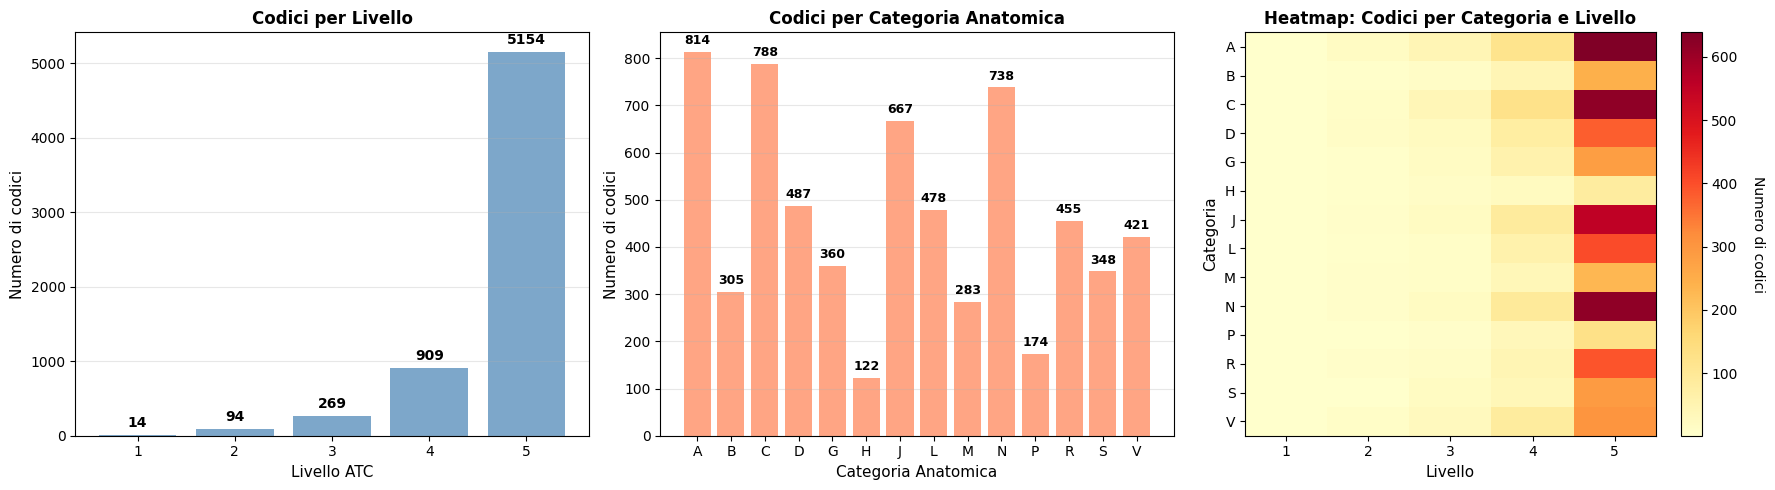

Totale codici: 6440
Numero livelli: 5
Numero categorie anatomiche: 14


In [18]:
plot_atc_statistics(atc)

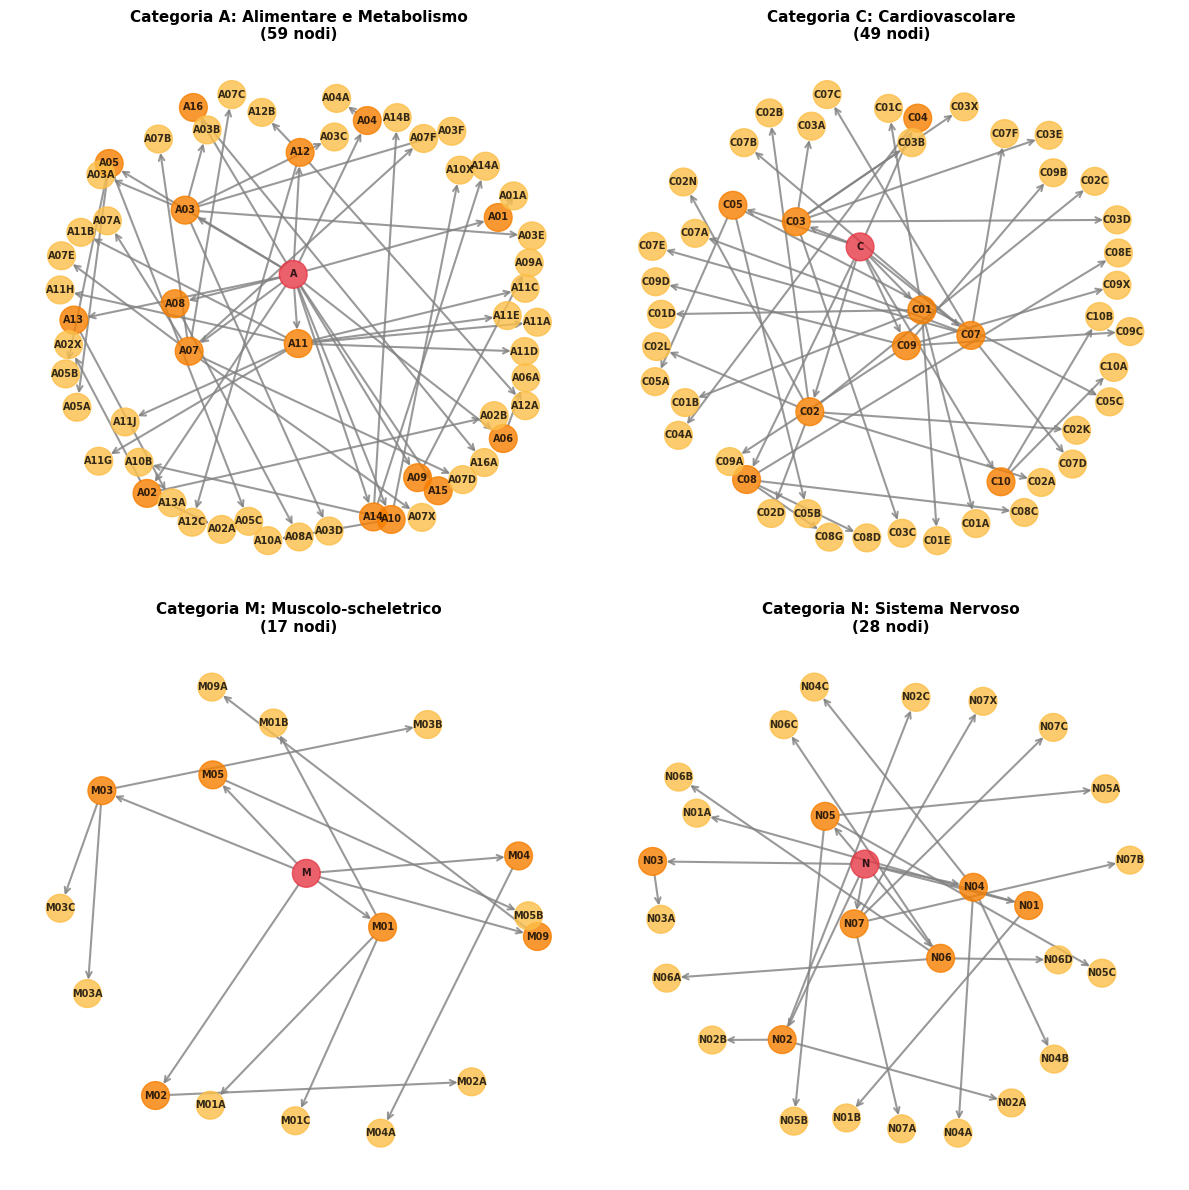

In [19]:
plot_category_subgraphs(atc, categorie=("A","C","M","N"), max_livello=3)

Varianza spiegata dalle 2 componenti: 56.7%


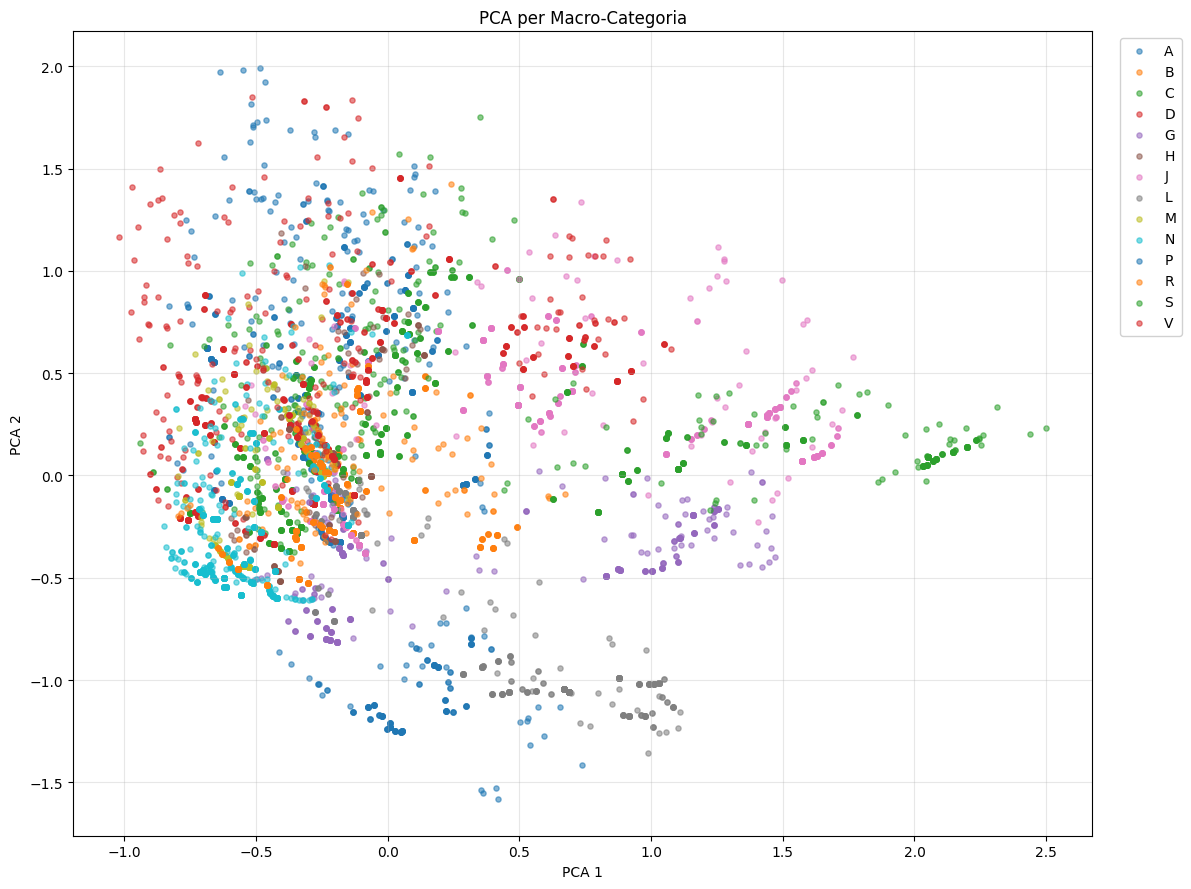

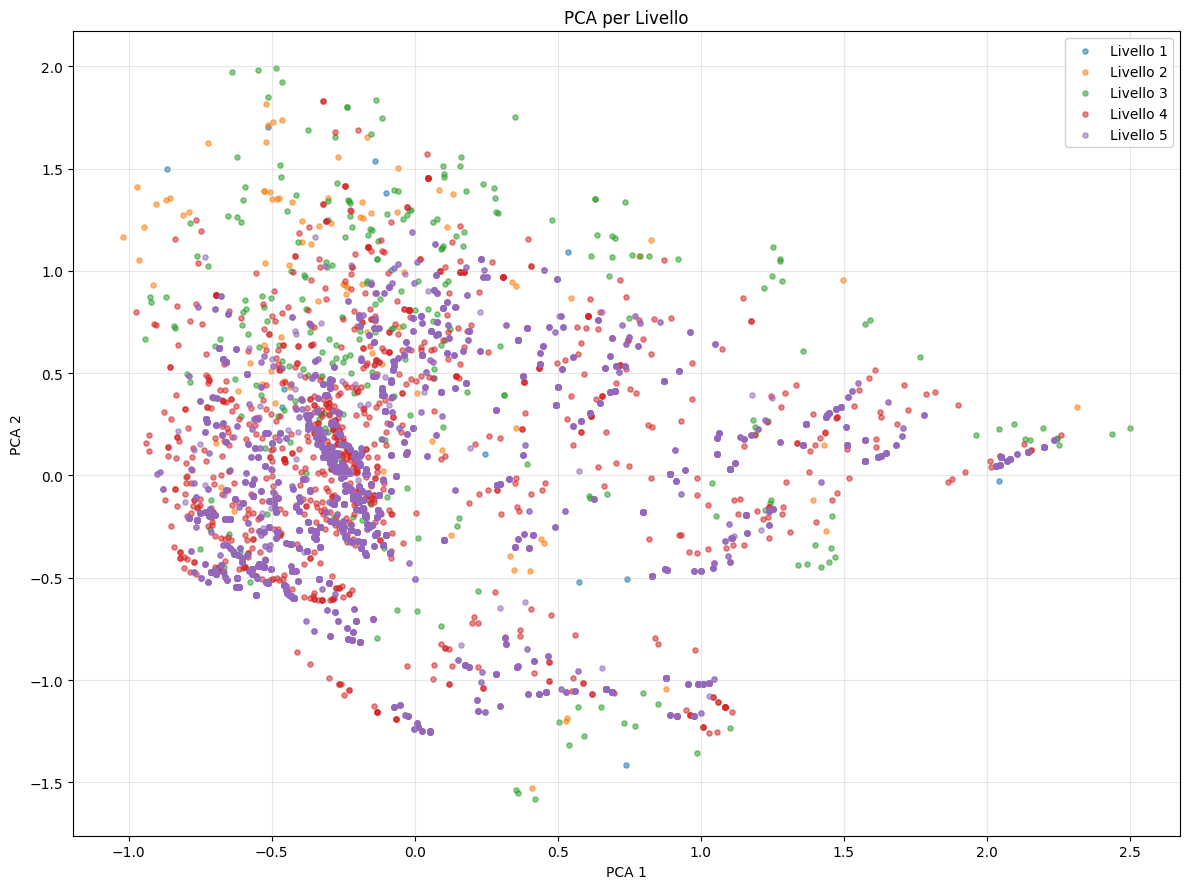

In [20]:
plot_global_atc_embeddings_pca(atc_embeddings, atc, atc_idx, max_level=5)

Embeddings shape: (6440, 128)


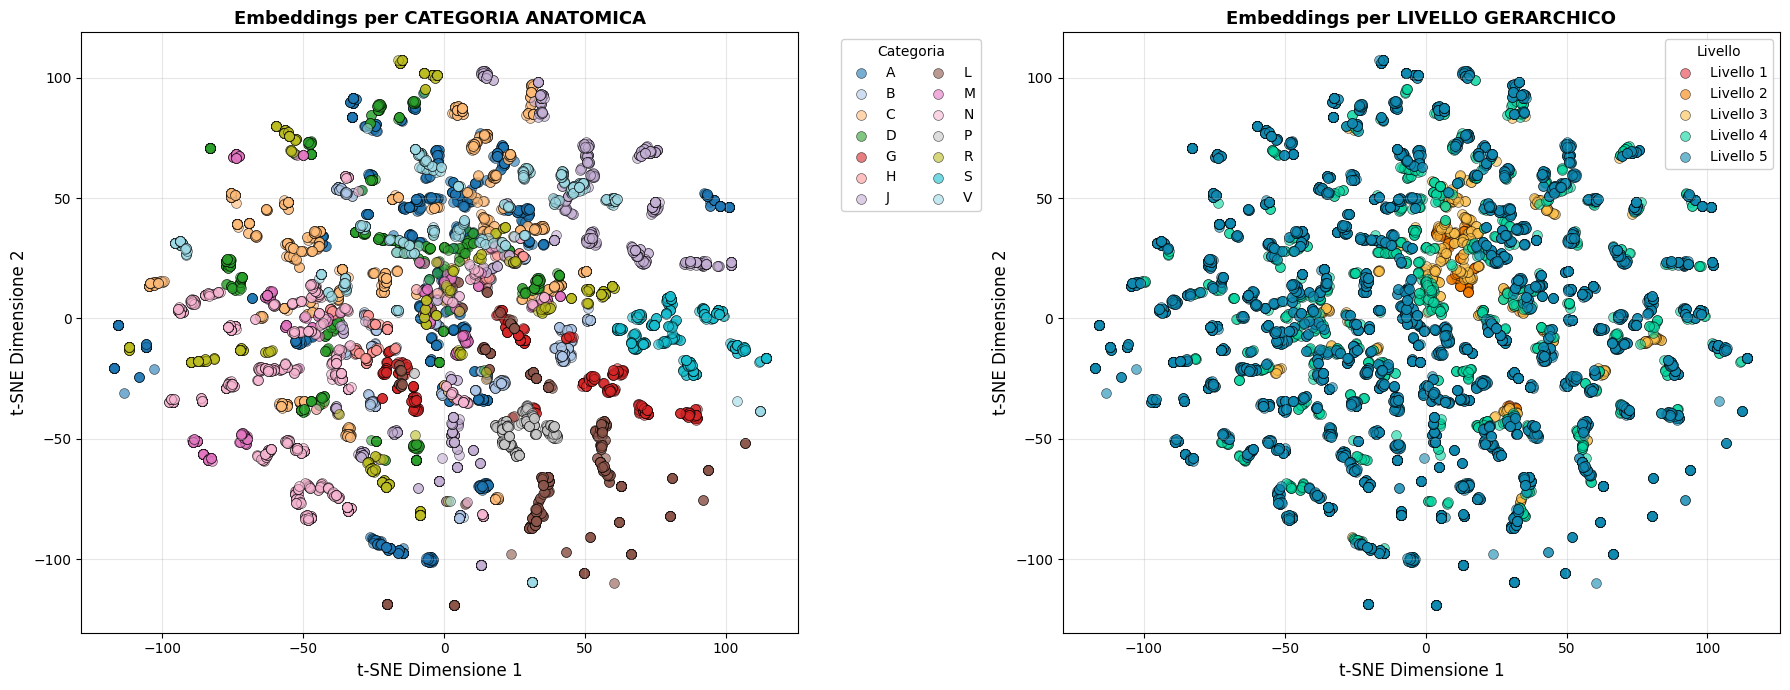

In [21]:
df_plot = plot_embeddings_tsne(atc_embeddings, atc, atc_idx)

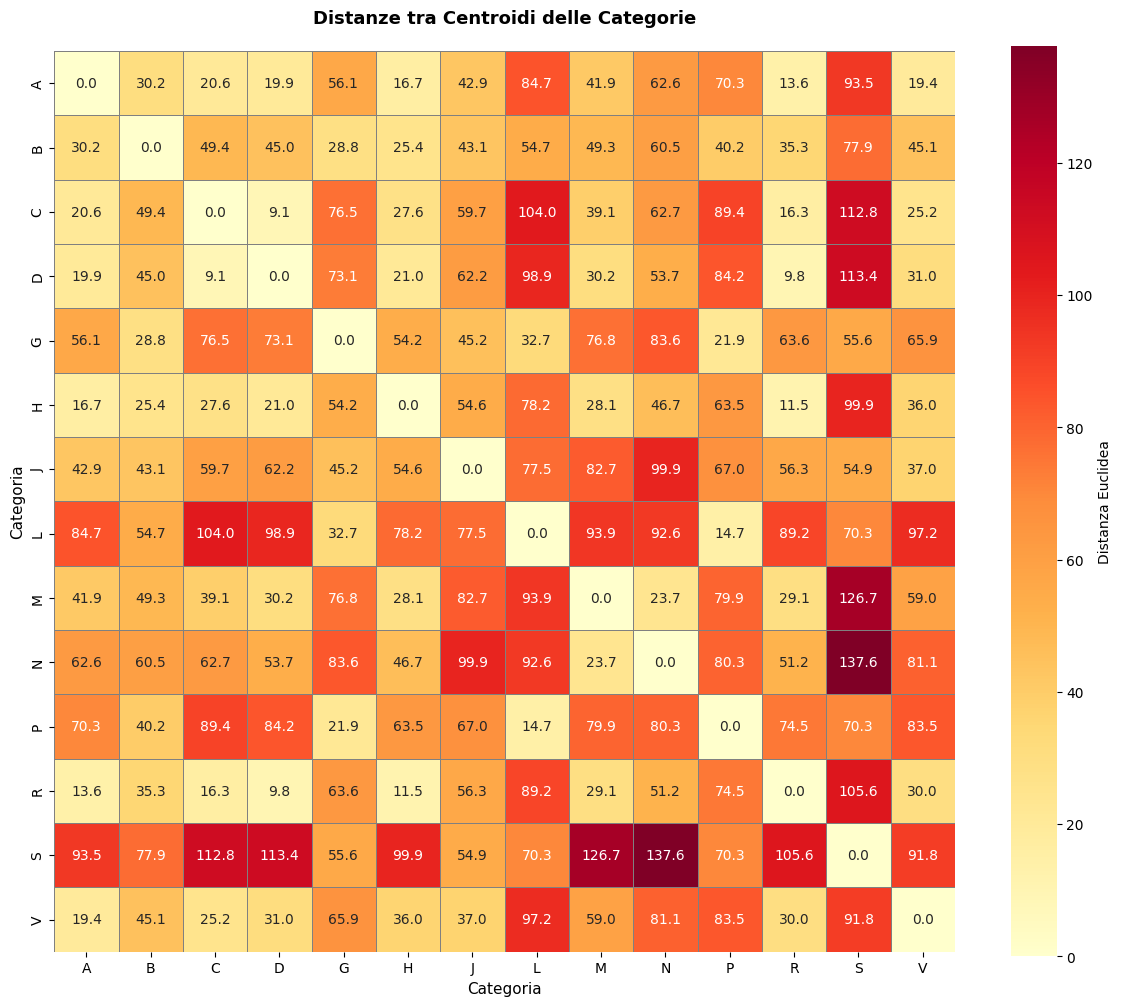

STATISTICHE DISTANZE (T-SNE):
Distanza media tra categorie: 58.26
Distanza minima: 9.09
Distanza massima: 137.61
Deviazione standard: 29.36
COPPIE ESTREME:
Più VICINE: C ↔ D (distanza: 9.09)
Più LONTANE: N ↔ S (distanza: 137.61)


In [22]:
analyze_category_separation(df_plot)

Varianza spiegata dalle 2 componenti PCA: 56.7%


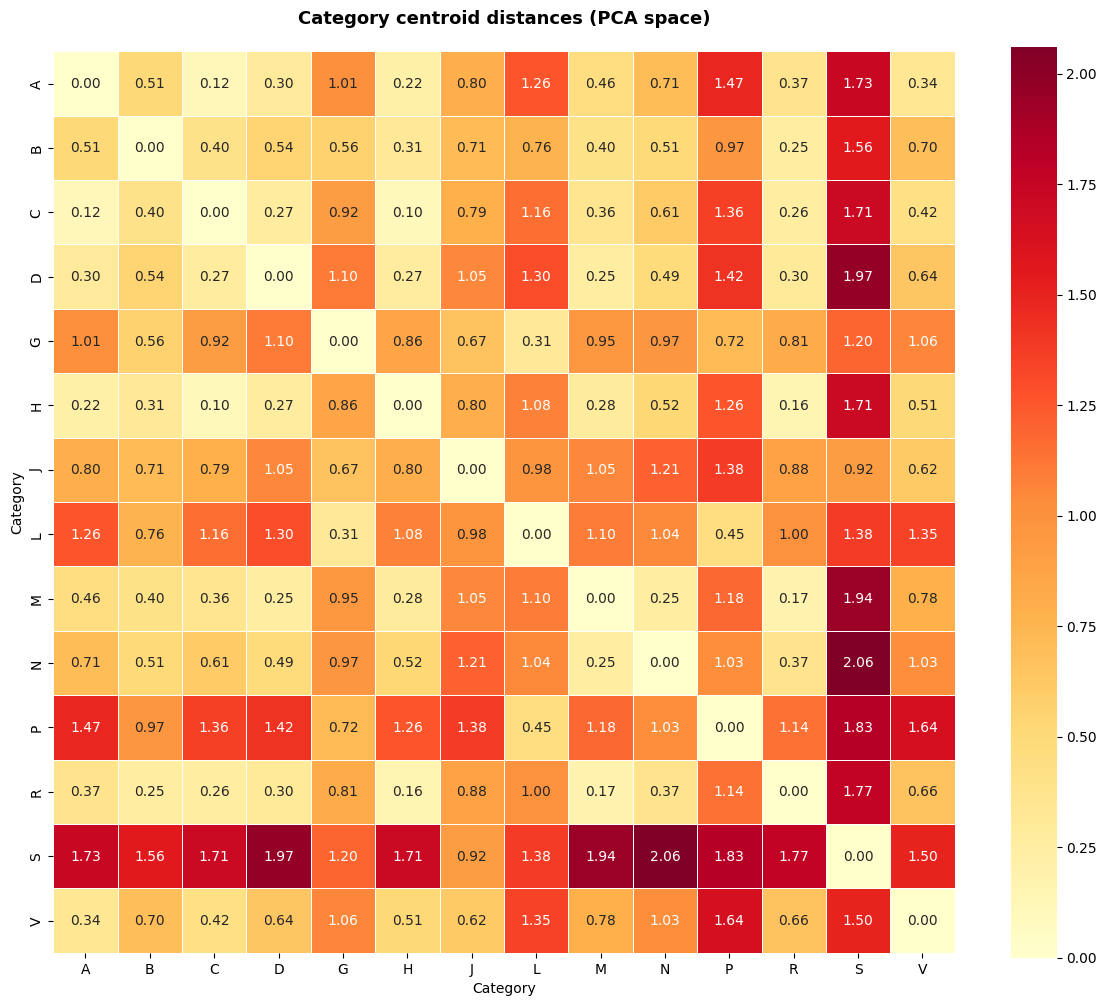


STATISTICHE DISTANZE (PCA):
Distanza media: 0.86
Distanza minima: 0.10
Distanza massima: 2.06
Deviazione standard: 0.49

COPPIE ESTREME (PCA):
Più VICINE: C ↔ H (distanza: 0.10)
Più LONTANE: N ↔ S (distanza: 2.06)


In [23]:
analyze_category_separation_pca(atc_embeddings, atc, atc_idx)